In [ ]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
import math
import itertools
import re
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from src import analysis
from src import framework
from src import ab_tests
from src.framework import print_title

In [3]:
import importlib
importlib.reload(analysis)
importlib.reload(framework)
importlib.reload(ab_tests)

<module 'src.ab_tests' from '/Users/jobandtalent/Documents/GitHub/ab-test-framework/src/ab_tests.py'>

# EXPERIMENT RESULTS

## SOURCES INGESTION

### LOAD

In [4]:
# Load raw data
file_name = 'ab_test_example_3.csv'
df_raw = pd.read_csv('../data/' + file_name)
display(df_raw.head(5))

# Make a copy
df = df_raw.copy()

# Check dtypes
print_title('INITIAL DATA TYPES')
print(df.dtypes)

,U_ID,VARIANT,USER_SEGMENT,PROMO_TAG,PROMOTER_U_ID,IS_TREATMENT,WHEN_ENTERED_INTO_EXPERIMENT,COUNT_TRANSFERS,DAYS_TRANSACTING,DISTINCT_RECEIVERS,TOTAL_TRANSFER_AMOUNT
0,203,CONTROL,MONTHLY_ACTIVE,sms_enrolment,NaN,0,2023-06-02 15:33:01,0,99,0,NaN
1,1577,CONTROL,MONTHLY_ACTIVE,sms_enrolment,NaN,0,2023-06-02 15:32:44,0,99,0,NaN
2,3326,CONTROL,MONTHLY_ACTIVE,sms_enrolment,NaN,0,2023-06-02 15:32:22,0,99,0,NaN
3,6004,CONTROL,MONTHLY_ACTIVE,sms_enrolment,NaN,0,2023-06-02 15:31:51,0,99,0,NaN
4,8643,CONTROL,MONTHLY_ACTIVE,sms_enrolment,NaN,0,2023-06-02 15:31:20,0,99,0,NaN


-------------------- INITIAL DATA TYPES --------------------
U_ID                              int64
VARIANT                          object
USER_SEGMENT                     object
PROMO_TAG                        object
PROMOTER_U_ID                   float64
IS_TREATMENT                      int64
WHEN_ENTERED_INTO_EXPERIMENT     object
COUNT_TRANSFERS                   int64
DAYS_TRANSACTING                  int64
DISTINCT_RECEIVERS                int64
TOTAL_TRANSFER_AMOUNT           float64
dtype: object


### DTYPES

In [5]:
datetime_columns = ['WHEN_ENTERED_INTO_EXPERIMENT']
int64_columns = ['U_ID', 'PROMOTER_U_ID', 'IS_TREATMENT', 'COUNT_TRANSFERS', 'DAYS_TRANSACTING', 'DISTINCT_RECEIVERS']
float64_columns = ['TOTAL_TRANSFER_AMOUNT']
str_columns = ['VARIANT', 'USER_SEGMENT', 'PROMO_TAG']

# Basic data conversion
df = framework.format_columns(df, datetime_columns, int64_columns, float64_columns, str_columns)

# Check dtypes
print_title('CONVERTED DATA TYPES')
print(df.dtypes)
display(df.head(5))

------------------- CONVERTED DATA TYPES -------------------
U_ID                                     Int64
VARIANT                                 object
USER_SEGMENT                            object
PROMO_TAG                               object
PROMOTER_U_ID                            Int64
IS_TREATMENT                             Int64
WHEN_ENTERED_INTO_EXPERIMENT    datetime64[ns]
COUNT_TRANSFERS                          Int64
DAYS_TRANSACTING                         Int64
DISTINCT_RECEIVERS                       Int64
TOTAL_TRANSFER_AMOUNT                  float64
dtype: object


,U_ID,VARIANT,USER_SEGMENT,PROMO_TAG,PROMOTER_U_ID,IS_TREATMENT,WHEN_ENTERED_INTO_EXPERIMENT,COUNT_TRANSFERS,DAYS_TRANSACTING,DISTINCT_RECEIVERS,TOTAL_TRANSFER_AMOUNT
0,203,CONTROL,MONTHLY_ACTIVE,sms_enrolment,<NA>,0,2023-06-02 15:33:01,0,99,0,NaN
1,1577,CONTROL,MONTHLY_ACTIVE,sms_enrolment,<NA>,0,2023-06-02 15:32:44,0,99,0,NaN
2,3326,CONTROL,MONTHLY_ACTIVE,sms_enrolment,<NA>,0,2023-06-02 15:32:22,0,99,0,NaN
3,6004,CONTROL,MONTHLY_ACTIVE,sms_enrolment,<NA>,0,2023-06-02 15:31:51,0,99,0,NaN
4,8643,CONTROL,MONTHLY_ACTIVE,sms_enrolment,<NA>,0,2023-06-02 15:31:20,0,99,0,NaN


## DATA CLEANING

### CHECKS

In [6]:
variant_column = 'VARIANT'

In [7]:
# Quick checks on data
print_title('DF INFO')
display(df.info())

print_title('DF DESCRIBE')
display(df.describe())

# Check distribution of variants
print_title('VARIANT DISTRIBUTION')
display(df[variant_column].value_counts())

------------------------- DF INFO -------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45623 entries, 0 to 45622
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   U_ID                          45623 non-null  Int64         
 1   VARIANT                       45623 non-null  object        
 2   USER_SEGMENT                  45623 non-null  object        
 3   PROMO_TAG                     45623 non-null  object        
 4   PROMOTER_U_ID                 29347 non-null  Int64         
 5   IS_TREATMENT                  45623 non-null  Int64         
 6   WHEN_ENTERED_INTO_EXPERIMENT  45623 non-null  datetime64[ns]
 7   COUNT_TRANSFERS               45623 non-null  Int64         
 8   DAYS_TRANSACTING              45623 non-null  Int64         
 9   DISTINCT_RECEIVERS            45623 non-null  Int64         
 10  TOTAL_TRANSFER_AMOUNT         1887

None

----------------------- DF DESCRIBE -----------------------


,U_ID,PROMOTER_U_ID,IS_TREATMENT,WHEN_ENTERED_INTO_EXPERIMENT,COUNT_TRANSFERS,DAYS_TRANSACTING,DISTINCT_RECEIVERS,TOTAL_TRANSFER_AMOUNT
count,45623.0,29347.0,45623.0,45623,45623.0,45623.0,45623.0,1.887700e+04
mean,22811.996164,21661038.772549,0.354426,2023-05-23 04:48:41.669684224,1.013677,0.879995,0.817548,5.374970e+04
min,1.0,655650.0,0.0,2023-04-18 00:56:14,0.0,0.0,0.0,5.000000e+00
25%,11406.5,8451570.0,0.0,2023-05-13 13:35:21.500000,0.0,0.0,0.0,2.000000e+03
50%,22812.0,18808489.0,0.0,2023-05-25 17:15:51,0.0,0.0,0.0,5.050000e+03
75%,34217.5,36522003.0,1.0,2023-06-01 15:37:50,1.0,1.0,1.0,2.938000e+04
max,45616.0,40557197.0,1.0,2023-06-29 18:37:31,241.0,99.0,219.0,1.201984e+07
std,13170.363363,13873536.242459,0.478344,NaN,2.910549,2.54671,2.138211,3.060536e+05


------------------- VARIANT DISTRIBUTION -------------------


VARIANT
CONTROL        29453
PRICE_PROMO    16170
Name: count, dtype: int64

### DUPLICATES

In [8]:
# Check for and drop duplicates in the entire DataFrame
duplicated_rows = df.duplicated().sum()
print('# of duplicated rows: ', duplicated_rows)

if duplicated_rows > 0:
    df = df.drop_duplicates()
    print('Duplicates in the DataFrame removed.')
else:
    print('No duplicates in the DataFrame found.')

# of duplicated rows:  0
No duplicates in the DataFrame found.


In [9]:
primary_key_column = 'U_ID'
timestamp_column = ''

# Check for duplicates in the unique columns
duplicated_rows = df[df[primary_key_column].duplicated(keep=False)]
print(f'# of duplicated on {primary_key_column} column: {duplicated_rows[primary_key_column].nunique()}')

if not duplicated_rows.empty:
    print(f'Duplicated {primary_key_column} and their rows:')
    display(duplicated_rows.sort_values(by = 'U_ID'))

    # Keep only the first following timestamp column order
    if timestamp_column == '':
        df = df.drop_duplicates(subset=primary_key_column, keep='last')
        print('Kept the most recent row for each duplicated U_ID.')
    else:
        df = df.sort_values(timestamp_column).drop_duplicates(subset=primary_key_column, keep='last')
        print('Kept the most recent row for each duplicated U_ID.')

# of duplicated on U_ID column: 7
Duplicated U_ID and their rows:


,U_ID,VARIANT,USER_SEGMENT,PROMO_TAG,PROMOTER_U_ID,IS_TREATMENT,WHEN_ENTERED_INTO_EXPERIMENT,COUNT_TRANSFERS,DAYS_TRANSACTING,DISTINCT_RECEIVERS,TOTAL_TRANSFER_AMOUNT
45599,45592,PRICE_PROMO,CHURNED,nan,8962332,1,2023-05-09 18:47:20,0,0,0,NaN
45616,45592,PRICE_PROMO,CHURNED,nan,11369216,1,2023-05-22 18:32:41,0,0,0,NaN
45600,45593,CONTROL,CHURNED,nan,26351398,0,2023-04-28 10:55:06,0,0,0,NaN
45617,45593,PRICE_PROMO,CHURNED,nan,11369216,1,2023-04-18 00:56:14,0,0,0,NaN
18887,45594,PRICE_PROMO,CHURNED,nan,38443462,1,2023-05-20 13:26:49,1,1,1,2500.0
45618,45594,PRICE_PROMO,CHURNED,nan,11369216,1,2023-04-18 00:56:14,0,0,0,NaN
45601,45595,PRICE_PROMO,CHURNED,nan,2903573,1,2023-05-10 16:58:04,0,0,0,NaN
45619,45595,PRICE_PROMO,CHURNED,nan,11369216,1,2023-04-18 00:56:14,0,0,0,NaN
18888,45596,CONTROL,CHURNED,nan,29387022,0,2023-05-15 11:13:23,1,1,1,1010.0
45620,45596,PRICE_PROMO,CHURNED,nan,11369216,1,2023-04-18 00:56:14,0,0,0,NaN


Kept the most recent row for each duplicated U_ID.


### NULLS

In [10]:
# Check for missing values
missing_values = df.isnull().sum()
print_title('NUMBER OF NULL VALUES')
print(missing_values)

------------------ NUMBER OF NULL VALUES ------------------
U_ID                                0
VARIANT                             0
USER_SEGMENT                        0
PROMO_TAG                           0
PROMOTER_U_ID                   16276
IS_TREATMENT                        0
WHEN_ENTERED_INTO_EXPERIMENT        0
COUNT_TRANSFERS                     0
DAYS_TRANSACTING                    0
DISTINCT_RECEIVERS                  0
TOTAL_TRANSFER_AMOUNT           26743
dtype: int64


In [11]:
# Fill null columns
df['TOTAL_TRANSFER_AMOUNT'] = df['TOTAL_TRANSFER_AMOUNT'].fillna(0)

### INCONSISTENCIES

In [12]:
# Checks errors in variant labeling
checks = df[(df['IS_TREATMENT'] == 1) & (df['VARIANT'] != 'PRICE_PROMO')]
display(checks)
checks = df[(df['IS_TREATMENT'] == 0) & (df['VARIANT'] != 'CONTROL')]
display(checks)

,U_ID,VARIANT,USER_SEGMENT,PROMO_TAG,PROMOTER_U_ID,IS_TREATMENT,WHEN_ENTERED_INTO_EXPERIMENT,COUNT_TRANSFERS,DAYS_TRANSACTING,DISTINCT_RECEIVERS,TOTAL_TRANSFER_AMOUNT


,U_ID,VARIANT,USER_SEGMENT,PROMO_TAG,PROMOTER_U_ID,IS_TREATMENT,WHEN_ENTERED_INTO_EXPERIMENT,COUNT_TRANSFERS,DAYS_TRANSACTING,DISTINCT_RECEIVERS,TOTAL_TRANSFER_AMOUNT


## METRICS DEFINITION

In [13]:
# calculate the metrics, use metric_cnt_ or metric_cvr_
df['metric_cnt_total_transfer_amount'] = df['TOTAL_TRANSFER_AMOUNT']
df['metric_cvr_transaction'] = df['TOTAL_TRANSFER_AMOUNT'].apply(lambda x: 1 if x > 0 else 0, 1)

/var/folders/hv/ckh3m6gn1sd45q2qctrqcwzh0000gn/T/ipykernel_32583/2439425549.py:3: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df['metric_cvr_transaction'] = df['TOTAL_TRANSFER_AMOUNT'].apply(lambda x: 1 if x > 0 else 0, 1)


## SEGMENT ANALYSIS

### METRICS AND CONFIG SELECTION

In [15]:
# Select metrics and columns involved in the test
primary_key_column = 'U_ID'
metric_column = 'metric_cnt_total_transfer_amount'
variant_column = 'VARIANT'

columns_selection_df = df[[primary_key_column, variant_column, metric_column]]
metric_type = (
    'continuous' if metric_column.startswith('metric_cnt_') else
    'proportion' if metric_column.startswith('metric_cvr_') else
    None
)
outliers_filtered_df, is_strong_outlier_effect = analysis.remove_outliers(columns_selection_df, metric_column, 1)

# Filter outliers:
filter_outliers = False

if filter_outliers:
    selected_df = outliers_filtered_df.copy()
else:
    selected_df = columns_selection_df.copy()

display(selected_df.sample(5))

Low outlier limit: -5650.0
Upper outlier limit: 11300.0
Filtered 7183 rows (15.75%) from 45616 to 38433
is_strong_outlier_effect: True


,U_ID,VARIANT,metric_cnt_total_transfer_amount
13475,21908,CONTROL,2020.0
5277,10109,PRICE_PROMO,5500.0
7687,2794,CONTROL,60600.0
18355,43767,PRICE_PROMO,1000.0
12571,19768,CONTROL,2020.0


### DATA ANALYSIS AND STATISTICAL TESTING BY SEGMENTS

In [16]:
if True:
    selected_df = framework.add_segment_column(selected_df, num_segments=4)
display(selected_df)

,U_ID,VARIANT,metric_cnt_total_transfer_amount,segment
0,203,CONTROL,0.0,segment_3
1,1577,CONTROL,0.0,segment_4
2,3326,CONTROL,0.0,segment_1
3,6004,CONTROL,0.0,segment_3
4,8643,CONTROL,0.0,segment_3
...,...,...,...,...
45618,45594,PRICE_PROMO,0.0,segment_1
45619,45595,PRICE_PROMO,0.0,segment_4
45620,45596,PRICE_PROMO,0.0,segment_4
45621,45597,PRICE_PROMO,0.0,segment_1


====================================================================== SEGMENT: segment_3 ======================================================================
::::::::::::::::::::::::::::::::::::::::::::::::::::::::: DATA ANALYSIS :::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Number of Variants: 2
Variants: ['CONTROL' 'PRICE_PROMO']
Sample sizes per variant:
VARIANT
CONTROL        7273
PRICE_PROMO    4039
Name: count, dtype: int64

Proportion per variant:
VARIANT
CONTROL        0.642946
PRICE_PROMO    0.357054
Name: count, dtype: float64

Variant Ratio (N = max/min): 1.80
------------------------------- NORMAL DISTRIBUTION VISUAL ANALYSIS -------------------------------


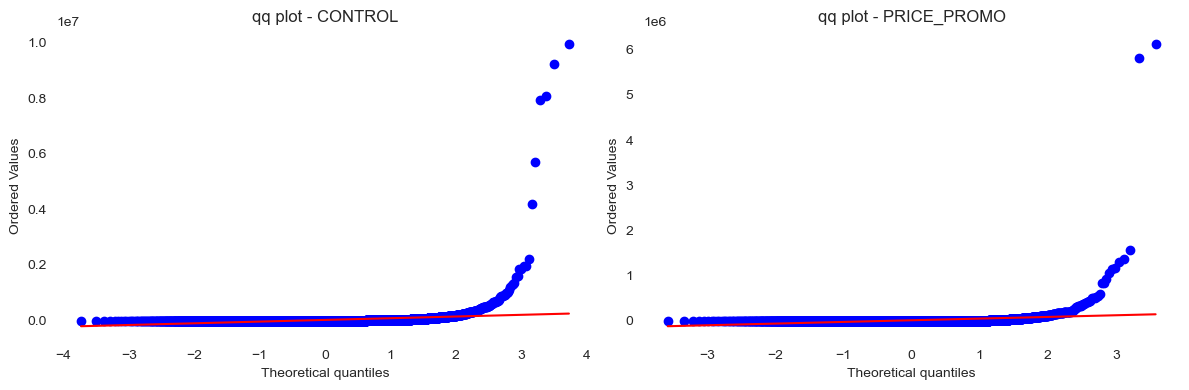

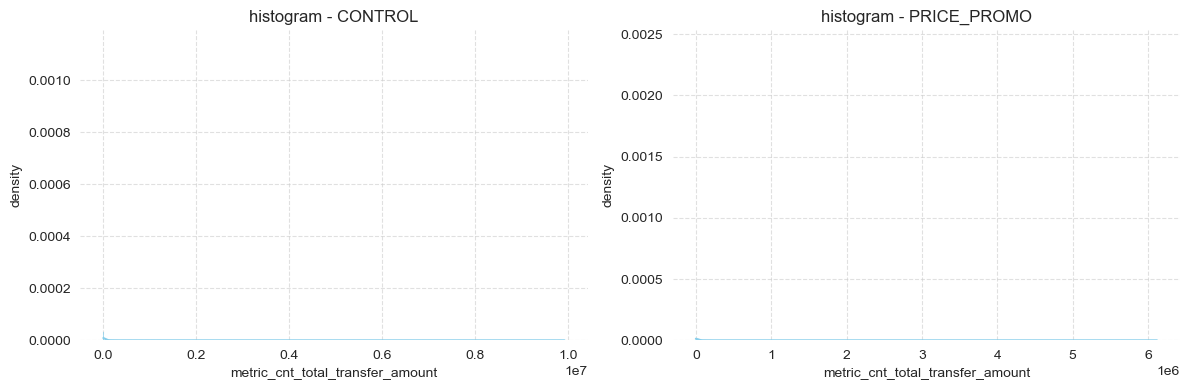

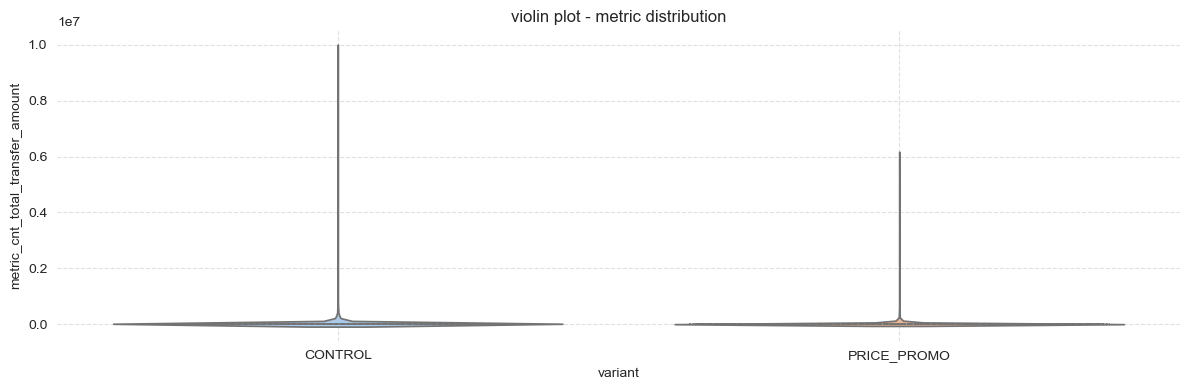

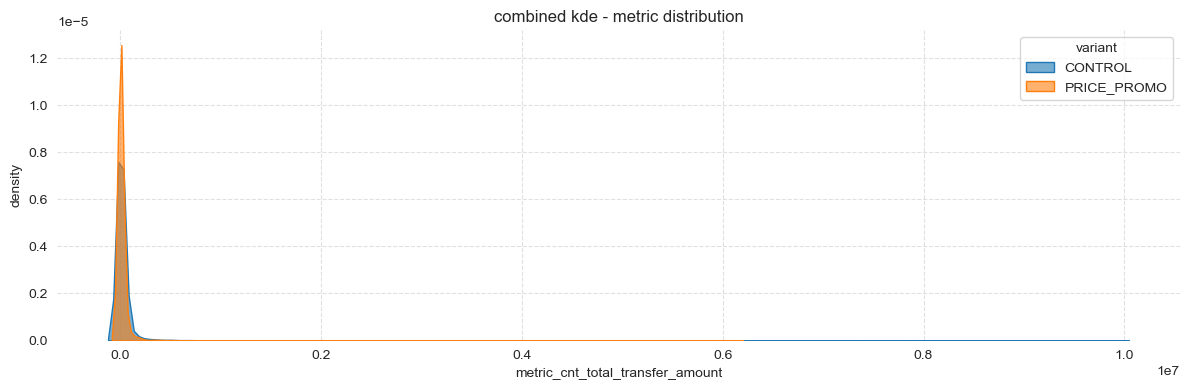

--------------------------------- NORMAL DISTRIBUTION TEST RESULTS ---------------------------------
variant CONTROL: normaltest statistic = 18981.6091, p-value = 0.0000
variant PRICE_PROMO: shapiro statistic = 0.0630, p-value = 0.0000

USE NORMAL DISTRIBUTION TESTS: False
-------------------------------------- VARIANCE TEST RESULTS --------------------------------------
Levene test statistic = 5.9678, p_value = 0.0146
Equal variance assumption: False

USE EQUAL VARIANCE TESTS: False
::::::::::::::::::::::::::::::::::::::::::::::::::::::: STATISICAL TESTING :::::::::::::::::::::::::::::::::::::::::::::::::::::::
------------------------------------------ TEST VARIABLES ------------------------------------------
metric_type: continuous
is_normal_distribution: False
is_equal_variance: False
num_variants: 2
sample_sizes: VARIANT
CONTROL        7273
PRICE_PROMO    4039
Name: count, dtype: int64
variant_ratio: 1.8
is_strong_outlier_effect: True


------------------------------------------ T

,group1,group2,p_value,significant
0,CONTROL,PRICE_PROMO,2.924410e-14,True


------------------------------------------ TEST SELECTION ------------------------------------------
{'use_mann_whitney_u_test': True, 'use_bayesian_test': True}


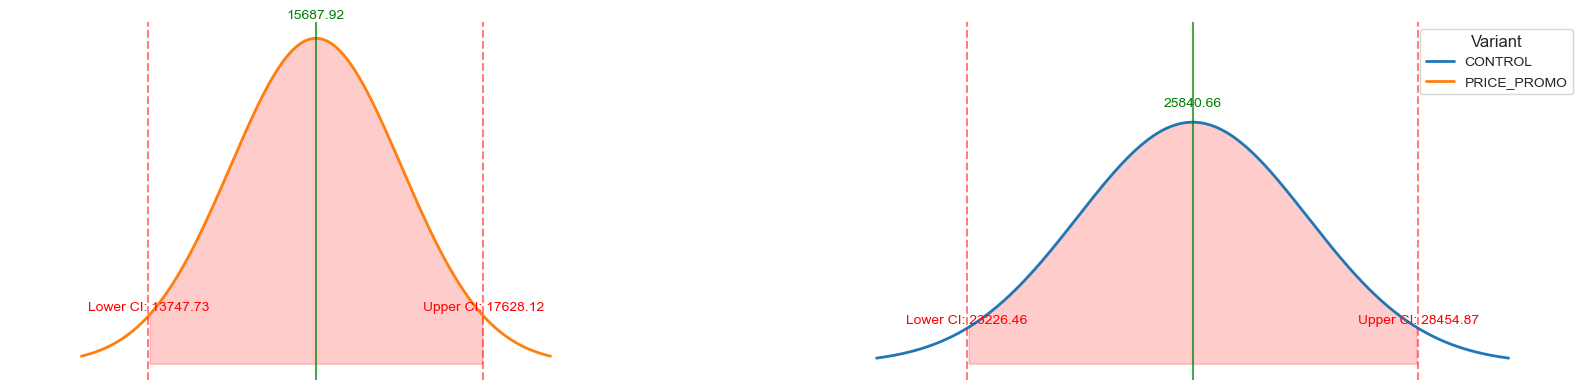

-------------------------------------- ADDITIONAL TECHNIQUES --------------------------------------


{'pairwise_tests': {'CONTROL vs PRICE_PROMO': {'bayesian_mean_difference': -10152.741375630214,
   'bayesian_probability': 0.4857}}}

====================================================================== SEGMENT: segment_4 ======================================================================
::::::::::::::::::::::::::::::::::::::::::::::::::::::::: DATA ANALYSIS :::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Number of Variants: 2
Variants: ['CONTROL' 'PRICE_PROMO']
Sample sizes per variant:
VARIANT
CONTROL        7451
PRICE_PROMO    4002
Name: count, dtype: int64

Proportion per variant:
VARIANT
CONTROL        0.650572
PRICE_PROMO    0.349428
Name: count, dtype: float64

Variant Ratio (N = max/min): 1.86
------------------------------- NORMAL DISTRIBUTION VISUAL ANALYSIS -------------------------------


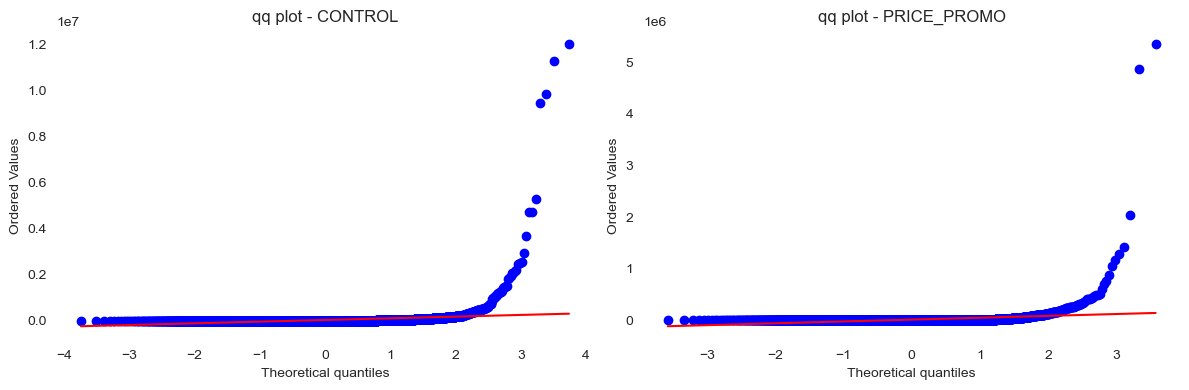

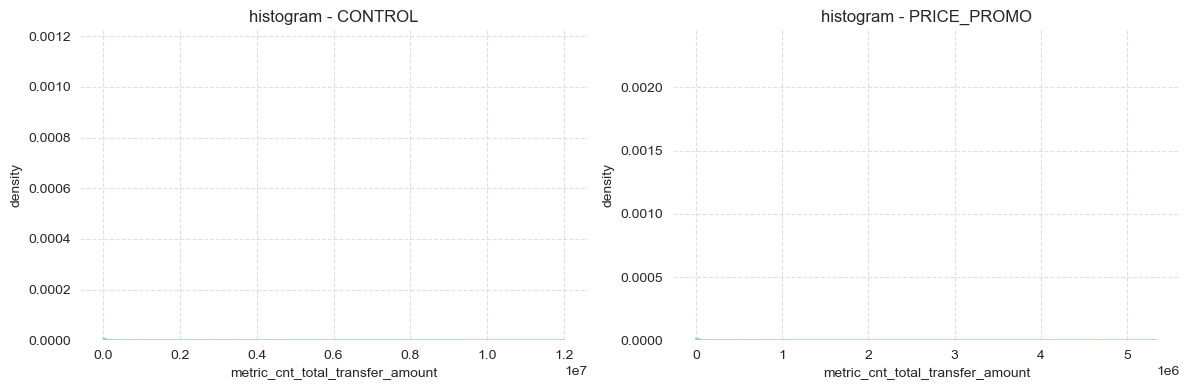

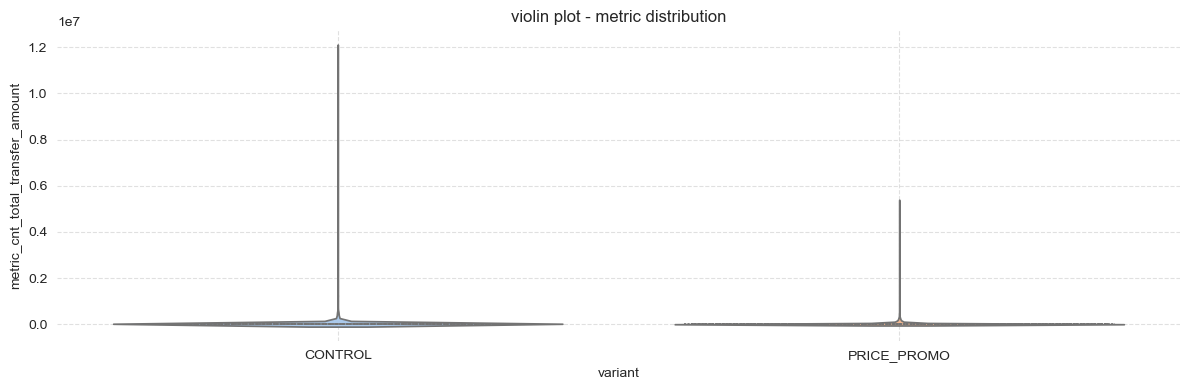

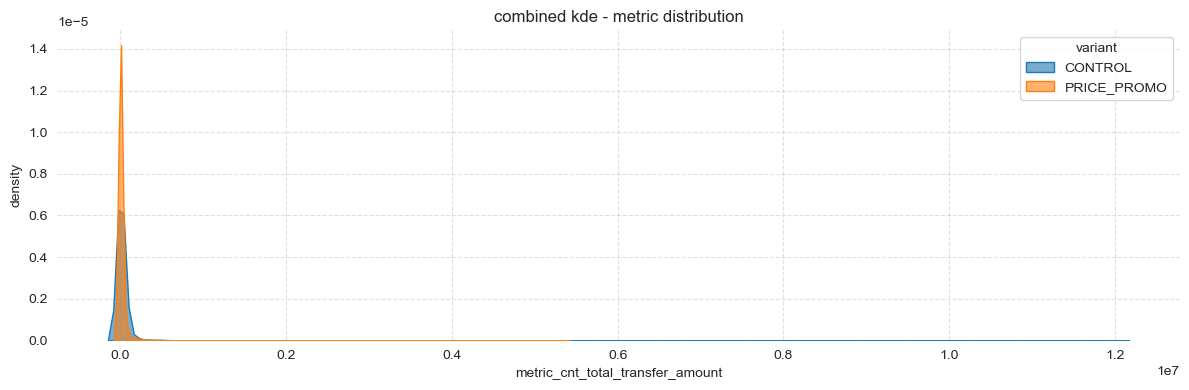

--------------------------------- NORMAL DISTRIBUTION TEST RESULTS ---------------------------------
variant CONTROL: normaltest statistic = 19058.9318, p-value = 0.0000
variant PRICE_PROMO: shapiro statistic = 0.0749, p-value = 0.0000

USE NORMAL DISTRIBUTION TESTS: False
-------------------------------------- VARIANCE TEST RESULTS --------------------------------------
Levene test statistic = 8.4576, p_value = 0.0036
Equal variance assumption: False

USE EQUAL VARIANCE TESTS: False
::::::::::::::::::::::::::::::::::::::::::::::::::::::: STATISICAL TESTING :::::::::::::::::::::::::::::::::::::::::::::::::::::::
------------------------------------------ TEST VARIABLES ------------------------------------------
metric_type: continuous
is_normal_distribution: False
is_equal_variance: False
num_variants: 2
sample_sizes: VARIANT
CONTROL        7451
PRICE_PROMO    4002
Name: count, dtype: int64
variant_ratio: 1.86
is_strong_outlier_effect: True


------------------------------------------ 

,group1,group2,p_value,significant
0,CONTROL,PRICE_PROMO,2.924410e-14,True


------------------------------------------ TEST SELECTION ------------------------------------------
{'use_mann_whitney_u_test': True, 'use_bayesian_test': True}


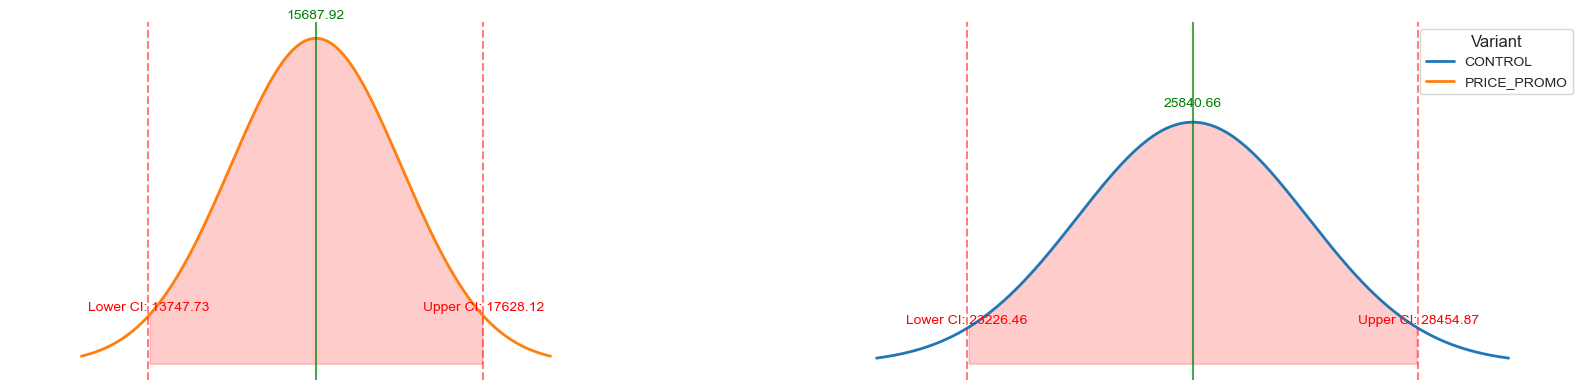

-------------------------------------- ADDITIONAL TECHNIQUES --------------------------------------


{'pairwise_tests': {'CONTROL vs PRICE_PROMO': {'bayesian_mean_difference': -10152.741375630214,
   'bayesian_probability': 0.4914}}}

====================================================================== SEGMENT: segment_1 ======================================================================
::::::::::::::::::::::::::::::::::::::::::::::::::::::::: DATA ANALYSIS :::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Number of Variants: 2
Variants: ['CONTROL' 'PRICE_PROMO']
Sample sizes per variant:
VARIANT
CONTROL        7352
PRICE_PROMO    4149
Name: count, dtype: int64

Proportion per variant:
VARIANT
CONTROL        0.639249
PRICE_PROMO    0.360751
Name: count, dtype: float64

Variant Ratio (N = max/min): 1.77
------------------------------- NORMAL DISTRIBUTION VISUAL ANALYSIS -------------------------------


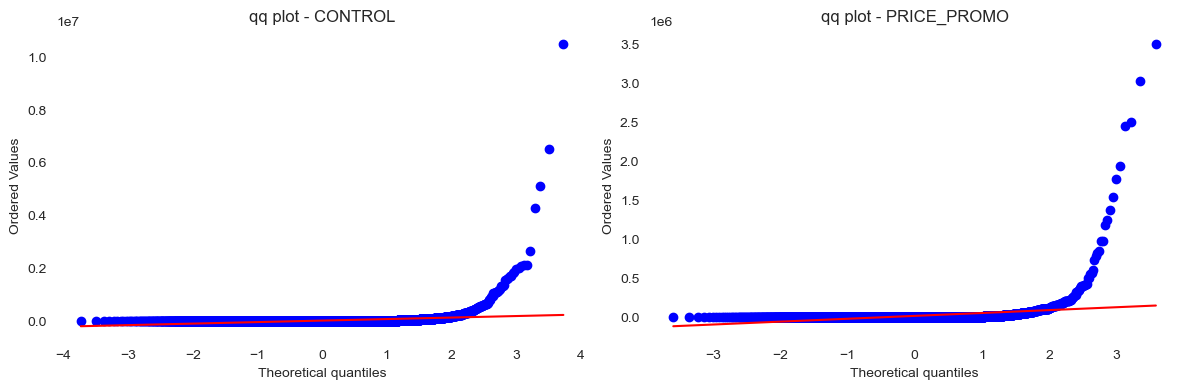

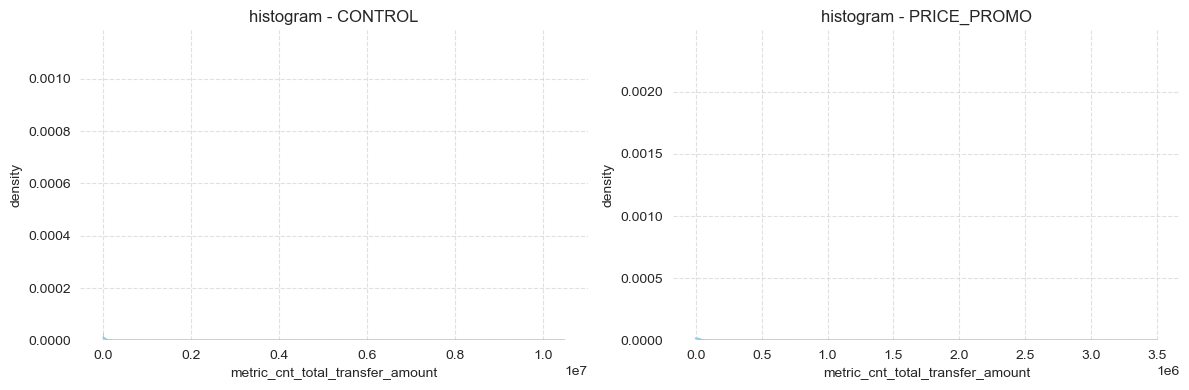

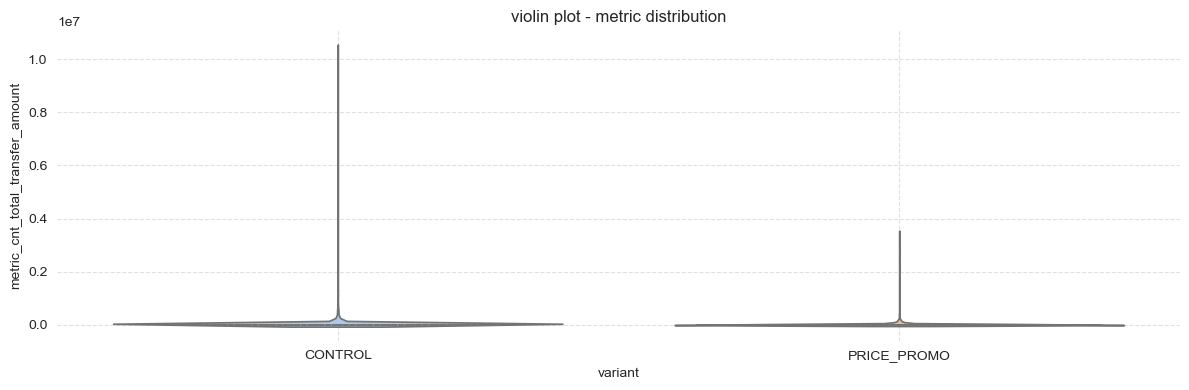

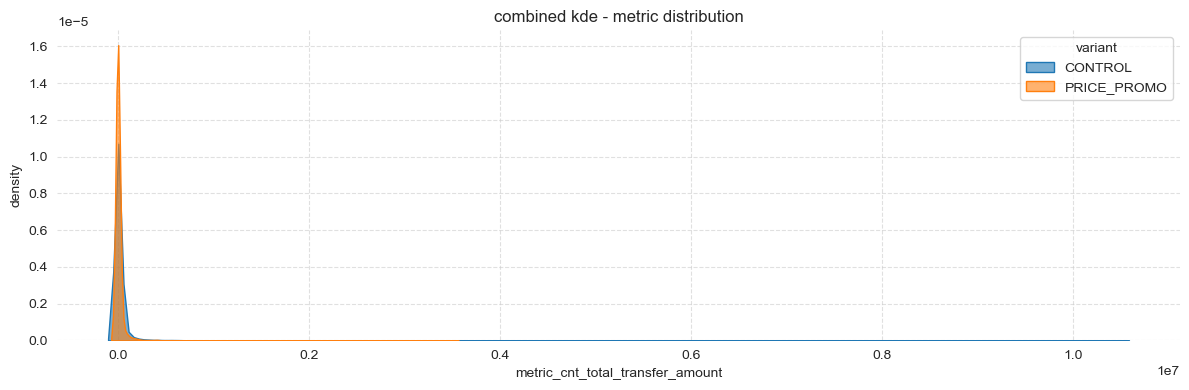

--------------------------------- NORMAL DISTRIBUTION TEST RESULTS ---------------------------------
variant CONTROL: normaltest statistic = 19370.8106, p-value = 0.0000
variant PRICE_PROMO: shapiro statistic = 0.0998, p-value = 0.0000

USE NORMAL DISTRIBUTION TESTS: False
-------------------------------------- VARIANCE TEST RESULTS --------------------------------------
Levene test statistic = 7.0690, p_value = 0.0079
Equal variance assumption: False

USE EQUAL VARIANCE TESTS: False
::::::::::::::::::::::::::::::::::::::::::::::::::::::: STATISICAL TESTING :::::::::::::::::::::::::::::::::::::::::::::::::::::::
------------------------------------------ TEST VARIABLES ------------------------------------------
metric_type: continuous
is_normal_distribution: False
is_equal_variance: False
num_variants: 2
sample_sizes: VARIANT
CONTROL        7352
PRICE_PROMO    4149
Name: count, dtype: int64
variant_ratio: 1.77
is_strong_outlier_effect: True


------------------------------------------ 

,group1,group2,p_value,significant
0,CONTROL,PRICE_PROMO,2.924410e-14,True


------------------------------------------ TEST SELECTION ------------------------------------------
{'use_mann_whitney_u_test': True, 'use_bayesian_test': True}


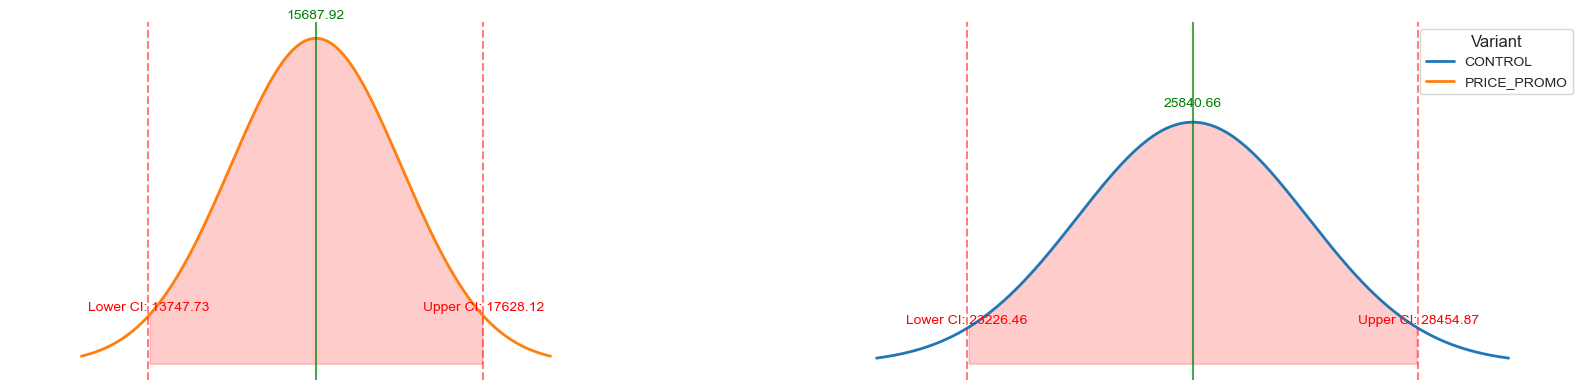

-------------------------------------- ADDITIONAL TECHNIQUES --------------------------------------


{'pairwise_tests': {'CONTROL vs PRICE_PROMO': {'bayesian_mean_difference': -10152.741375630214,
   'bayesian_probability': 0.487}}}

====================================================================== SEGMENT: segment_2 ======================================================================
::::::::::::::::::::::::::::::::::::::::::::::::::::::::: DATA ANALYSIS :::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Number of Variants: 2
Variants: ['CONTROL' 'PRICE_PROMO']
Sample sizes per variant:
VARIANT
CONTROL        7374
PRICE_PROMO    3976
Name: count, dtype: int64

Proportion per variant:
VARIANT
CONTROL        0.649692
PRICE_PROMO    0.350308
Name: count, dtype: float64

Variant Ratio (N = max/min): 1.85
------------------------------- NORMAL DISTRIBUTION VISUAL ANALYSIS -------------------------------


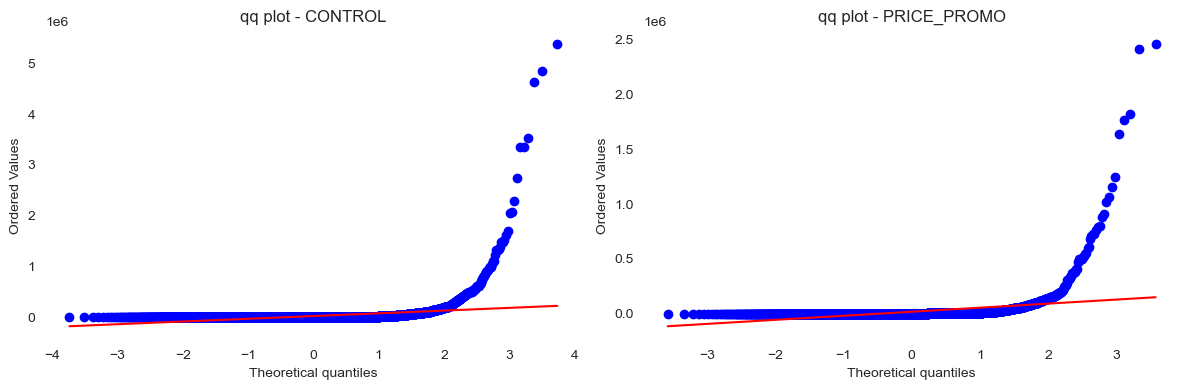

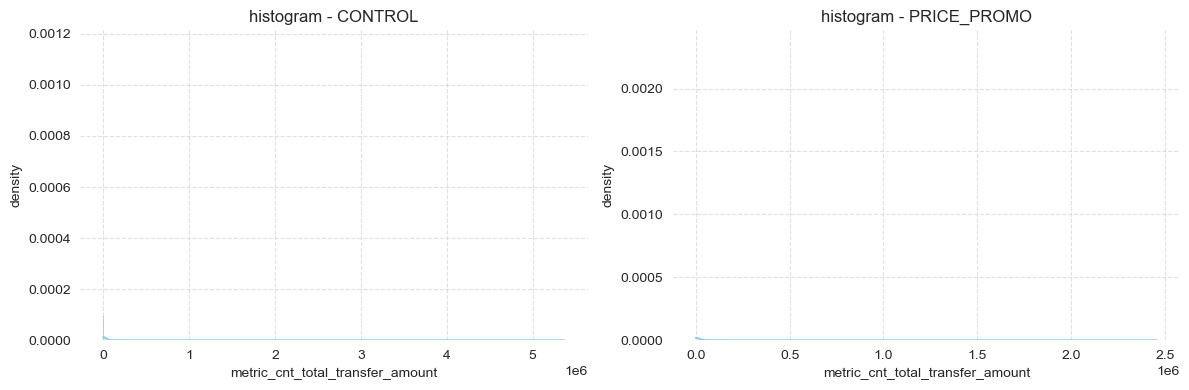

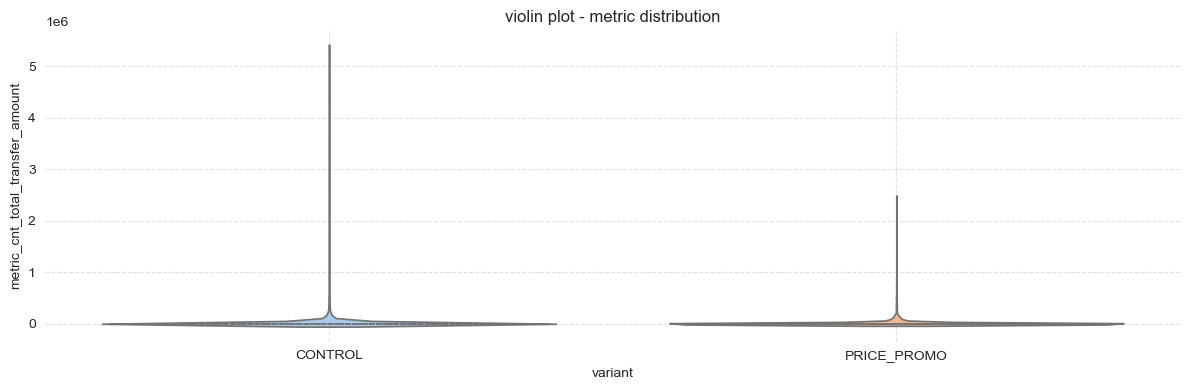

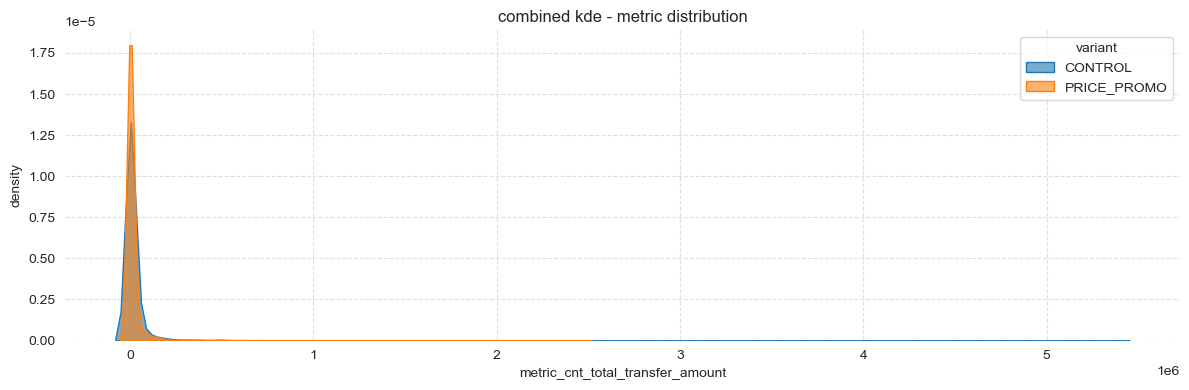

--------------------------------- NORMAL DISTRIBUTION TEST RESULTS ---------------------------------
variant CONTROL: normaltest statistic = 16083.2417, p-value = 0.0000
variant PRICE_PROMO: shapiro statistic = 0.1418, p-value = 0.0000

USE NORMAL DISTRIBUTION TESTS: False
-------------------------------------- VARIANCE TEST RESULTS --------------------------------------
Levene test statistic = 6.6869, p_value = 0.0097
Equal variance assumption: False

USE EQUAL VARIANCE TESTS: False
::::::::::::::::::::::::::::::::::::::::::::::::::::::: STATISICAL TESTING :::::::::::::::::::::::::::::::::::::::::::::::::::::::
------------------------------------------ TEST VARIABLES ------------------------------------------
metric_type: continuous
is_normal_distribution: False
is_equal_variance: False
num_variants: 2
sample_sizes: VARIANT
CONTROL        7374
PRICE_PROMO    3976
Name: count, dtype: int64
variant_ratio: 1.85
is_strong_outlier_effect: True


------------------------------------------ 

,group1,group2,p_value,significant
0,CONTROL,PRICE_PROMO,2.924410e-14,True


------------------------------------------ TEST SELECTION ------------------------------------------
{'use_mann_whitney_u_test': True, 'use_bayesian_test': True}


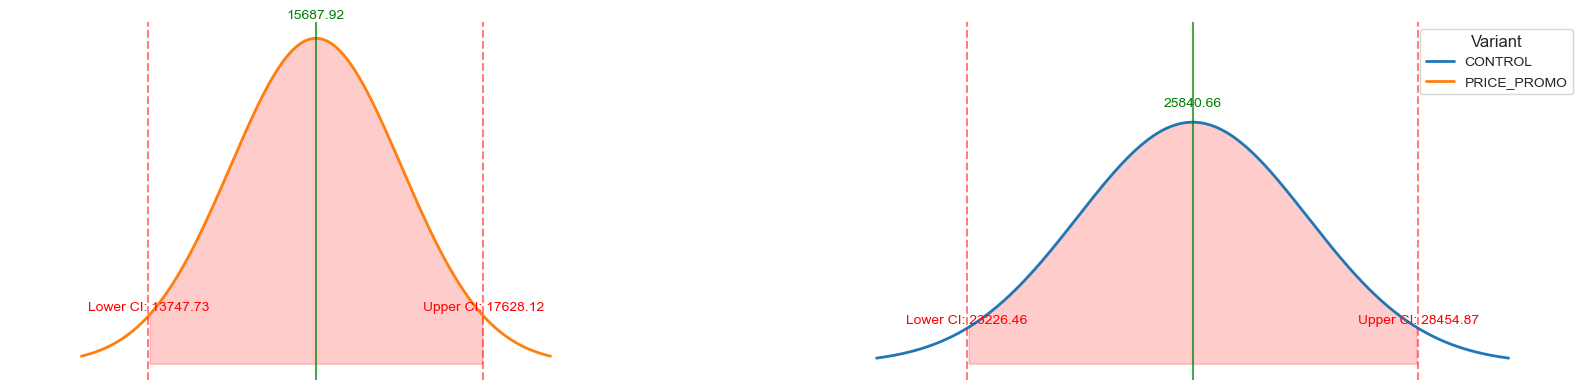

-------------------------------------- ADDITIONAL TECHNIQUES --------------------------------------


{'pairwise_tests': {'CONTROL vs PRICE_PROMO': {'bayesian_mean_difference': -10152.741375630214,
   'bayesian_probability': 0.4911}}}

In [20]:
segment_column = 'segment'
segments = selected_df[segment_column].unique()

for segment in segments:
    print_title('SEGMENT: ' + str(segment), 160, '=')
    print_title('DATA ANALYSIS', 130, ':')
    segment_df = selected_df[selected_df[segment_column] == segment]

    ### NUMBER OF VARIANTES
    num_variants = segment_df[variant_column].nunique()

    print(f"Number of Variants: {num_variants}")
    print(f"Variants: {segment_df[variant_column].unique()}")

    ### SAMPLE SIZES
    sample_sizes = segment_df[variant_column].value_counts()
    print("Sample sizes per variant:")
    print(sample_sizes)

    variant_proportion = sample_sizes / sample_sizes.sum()
    print("\nProportion per variant:")
    print(variant_proportion)

    variant_ratio = sample_sizes.max() / sample_sizes.min()
    print(f"\nVariant Ratio (N = max/min): {variant_ratio:.2f}")

    ### SAMPLE DISTRIBUTION
    sns.set_style("white")
    print_title('NORMAL DISTRIBUTION VISUAL ANALYSIS', 100)
    analysis.plot_qq(segment_df, variant_column, metric_column)
    analysis.plot_histogram_kde(segment_df, variant_column, metric_column)
    analysis.plot_violin(segment_df, variant_column, metric_column)
    analysis.plot_combined_kde(segment_df, variant_column, metric_column)

    print_title('NORMAL DISTRIBUTION TEST RESULTS', 100)
    distribution_results = analysis.calculate_distribution(segment_df, variant_column, metric_column)

    is_normal_distribution = analysis.set_normal_distribution_flag(distribution_results, alpha=0.05)
    print(f'\nUSE NORMAL DISTRIBUTION TESTS: {is_normal_distribution}')

    ### SAMPLE VARIANCES
    print_title('VARIANCE TEST RESULTS', 100)
    variance_results = analysis.calculate_variance_analysis(segment_df, variant_column, metric_column)

    is_equal_variance = analysis.set_equal_variance_flag(variance_results, alpha=0.05)
    print(f'\nUSE EQUAL VARIANCE TESTS: {is_equal_variance}')

    ## STATISICAL TESTING
    print_title('STATISICAL TESTING', 130, ':')
    ### TESTS AND TECHNIQUES SELECTION
    print_title('TEST VARIABLES', 100)
    ab_test_config = ab_tests.configure_ab_test(metric_type, is_equal_variance, is_normal_distribution, num_variants, variant_ratio, sample_sizes, is_strong_outlier_effect)
    print('\n')
    print_title('TEST SELECTION', 100)
    print({key: value for key, value in ab_test_config.items() if value})

    ### UNBALANCE DATA
    segment_df = ab_tests.resample_data(segment_df, ab_test_config, variant_column)

    ### TESTS
    print_title('TEST RESULTS', 100)
    standardized_results = ab_tests.run_complete_ab_test(ab_test_config, selected_df, variant_column, metric_column, num_variants, alpha = 0.05)
    display(standardized_results)

    print_title('TEST SELECTION', 100)
    print({key: value for key, value in ab_test_config.items() if value})

    framework.plot_distributions(selected_df, variant_column, metric_column, 0.05)

    ### ADDITIONAL TECHNIQUES
    print_title('ADDITIONAL TECHNIQUES', 100)
    additional_tests_results = ab_tests.apply_additional_tests(ab_test_config, selected_df, variant_column, metric_column)
    display(additional_tests_results)

### INTERACTIONS TESTS

In [18]:
## Interaction Tests, if discrepancies between segments
use_anova_interaction_test_segmentation = False # to test interaction effect between variant and segment, continuous, normal
use_welch_anova_interaction_test_segmentation = False # to test interaction effect between variant and segment, continuous, normal, can unbalanced
use_kruskal_wallis_interaction_test_segmentation = False # to test interaction effect between variant and segment, continuous, not normal
use_logistic_regression_interaction_test_segmentation = False # to test interaction effect for proportions, equivalent to ANOVA for categorical data
# if true, post hoc with tukey, games howell or dunn